In [1]:
# calculate kiwifruit 's each parts' mua, mus, with equal scale enlarge
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
from cycler import cycler
# import tensorflow as tf
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
import scipy as scipy
from scipy.optimize import minimize
# from scipy import signal
# from scipy import linalg
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential
import os
import gc
from sklearn.decomposition import PCA as PCA

In [2]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )

        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array
        

In [3]:
dict0 = {}
for i in range(1,100):
    dict0[i] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230210\\冷库\\Sample'+str(i)+'.txt'
dict0[0] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230210\\冷库\\irf00.txt'

dict1 = {}
for i in range(1,100):
    dict1[i] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230217\\冷库\\Sample'+str(i)+'.txt'
dict1[0] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230217\\冷库\\irf00.txt'

dict2 = {}
for i in range(1,100):
    dict2[i] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230224\\冷库\\Sample'+str(i)+'.txt'
dict2[0] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230224\\冷库\\irf00.txt'

dict3 = {}
for i in range(1,100):
    dict3[i] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230303\\冷库\\Sample'+str(i)+'.txt'
dict3[0] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230303\\冷库\\irf00.txt'

dict4 = {}
for i in range(1,100):
    dict4[i] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230310\\冷库\\Sample'+str(i)+'.txt'
dict4[0] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230310\\冷库\\irf00.txt'

dict5 = {}
for i in range(1,100):
    dict5[i] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230317\\冷库\\Sample'+str(i)+'.txt'
dict5[0] = 'D:\\files2\\Nagoya\\python\\kiwi_ToF_simulation\\feb\\20230317\\冷库\\irf00.txt'
dictn = [dict0,dict1,dict2,dict3,dict4,dict5]

In [4]:
class analyze(object):
    def __init__(self):

        return

    
    def read_everyday(self,dict0,radius):    
        # files = os.listdir(dict0[0][0:-10])   # 读入文件夹
        # N = len(files)       # 统计文件夹中的文件个数
        M = 100
        # scat = [None]*M
        data_480multi9 = np.zeros((M,480), dtype = float)
        time_index = np.zeros((M,480))

        scat = process_hyperspec(dict0[0], 0)
        scat.read_data()
        data_480multi9[0,:] = scat.cal_846nm()
        time_index[0] = scat.return_dataframe().index
        
        for i in range(1,M):
            if os.path.exists(dict0[i]):
                scat = process_hyperspec(dict0[i], i)
                scat.read_data()
                data_480multi9[i,:] = scat.cal_846nm()
                time_index[i] = scat.return_dataframe().index
            else:
                data_480multi9[i,:] = 0
                time_index[i] = 0
                
        return data_480multi9,time_index,M,radius

    def generate_h_y(self,data_480multi9,N):
        kernel0 = np.ones((10,))
        data_smooth = np.zeros((N-1,480))
        
        # for i in range(N-1):
        #     data_smooth[i] = np.convolve(kernel0,data_480multi9[i+1],'same')/np.sum(kernel0)

        def smooth(data):   #函数，用来平滑
            return np.convolve(kernel0,data,'same')/np.sum(kernel0)
        
        data_Y = data_480multi9[1:N]
        data_smooth = np.array([smooth(data_Y[i]) for i in range(data_Y.shape[0])])  #使用隐式循环来遍历

        y = np.zeros((data_smooth.shape[0],data_smooth.shape[1]*2-1))
        y[:,0:data_smooth.shape[1]] = data_smooth
        h = np.convolve(kernel0,data_480multi9[0],'same')/np.sum(kernel0)
        return h,y

In [5]:
class read_radius():
    def read_radius(self,AMOUNT_EXP):
        data1 = pd.read_excel('./kiwi_data.xlsx',sheet_name='冷库',header=None)
        data2 = np.nan_to_num(np.array(data1))
        r = data2[:,1]
        radius = [None]*AMOUNT_EXP
        radius[0] = r
        for i in range(1,AMOUNT_EXP):
            radius[i] = radius[i-1] 
        return radius

In [6]:
ana = analyze()
H = []
Y = []
TIME = []
R = []
AMOUNT_EXP = len(dictn)
read_radius_0 = read_radius()
radius = read_radius_0.read_radius(AMOUNT_EXP)

def iterate_AMOUNT_EXP(i):  #定义获取每个 H,Y,TIME,R 的方法
    data_480multi9,time_index,N,radius0 = ana.read_everyday(dictn[i],radius[i])
    h,y = ana.generate_h_y(data_480multi9,N)

    return h,y,time_index,radius0
H_Y_TIME_R = list(iterate_AMOUNT_EXP(i) for i in range(AMOUNT_EXP))
# for i in range(AMOUNT_EXP):
#     radius = ana.read_radius()
#     data_480multi9,time_index,N,radius0 = ana.read_everyday(dictn[i],radius)
#     h,y = ana.generate_h_y(data_480multi9,N)
#     H.append(h)
#     Y.append(y)
#     TIME.append(time_index)
#     R.append(radius0)
H = [H_Y_TIME_R[i][0] for i in range(len(H_Y_TIME_R))]
Y = [H_Y_TIME_R[i][1] for i in range(len(H_Y_TIME_R))]
TIME = [H_Y_TIME_R[i][2] for i in range(len(H_Y_TIME_R))]
R = [H_Y_TIME_R[i][3] for i in range(len(H_Y_TIME_R))]

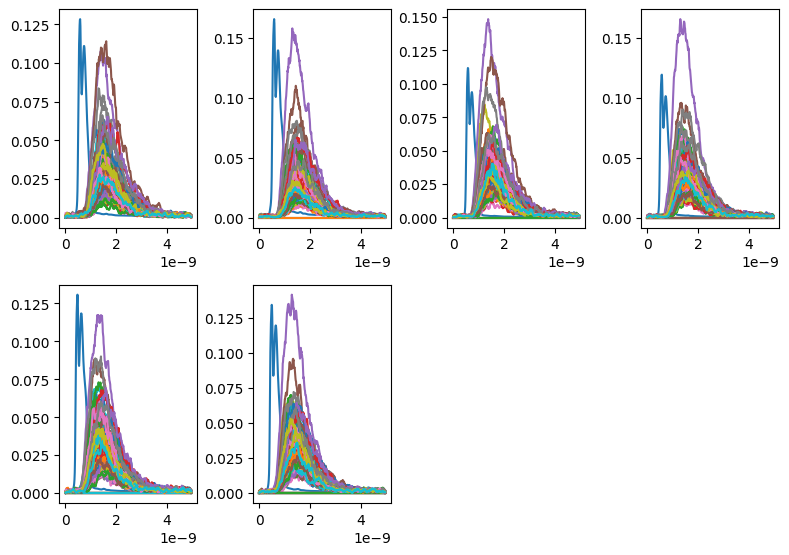

In [7]:
##########################################
fig = plt.figure(figsize = (8,8))
for i in range(AMOUNT_EXP):
    plt.subplot(3,4,i+1)
    plt.plot(TIME[0][i]*1e-9,H[i]/300)
    for j in range(Y[i].shape[0]):
        plt.plot(TIME[0][i]*1e-9,Y[i][j,0:480])
# plt.title.set_text(dict0[i][9:-4])
fig.tight_layout(pad=1.1)

plt.show()
##########################################
#把每一天的IRF画出来
# fig = plt.figure(figsize = (8,8))
# for i in range(AMOUNT_EXP):
#     plt.subplot(3,4,i+1)
    
#     plt.plot(TIME[0][i]*1e-9,H[i]/300)
        
# # plt.title.set_text(dict0[i][9:-4])
# fig.tight_layout(pad=1.1)

# plt.show()

In [8]:
# 找出奇异值，但是对冰箱样本不需要
index = 5
peak = np.zeros((Y[index].shape[0],))
for j in range(Y[index].shape[0]):
    peak[j] = np.max(Y[index][j,:])
peak1 = np.sort(peak)
exception = np.where(peak != 0)
print(exception[0])
# 36,64


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 82 83 84 85 86 87
 88 89 90 91 92 93 94 95 96 97 98]


In [62]:
class normalization():
    def get_irf_max(AMOUNT_EXP,H):
        max_irf = np.zeros((AMOUNT_EXP,))
        max_irf = np.array(list(map(lambda i:np.max(H[i]),range(AMOUNT_EXP))))
        return max_irf
    
    def get_normalized_Y(AMOUNT_EXP,Y,R,max_irf):
        Y_normalized = np.zeros((AMOUNT_EXP,Y.shape[1],959))
        for i in range(1,AMOUNT_EXP):
            for j in range(Y.shape[1]):
                MAX = np.max(Y[0,j])
                Y_normalized[i,j] = (Y[i,j]-Y[0,j])/MAX/max_irf[i]/R[i][j]  #/R[i][j]  /max_irf[i]/  /max_irf[i]/R[i][j]  -Y[0,j]
        
        Y_normalized[0] = Y[0] /max_irf[0]/R[0][j]    #   /max_irf[0]/R[0][j]
        return Y_normalized
    
    def split_Y2(Y,R,AMOUNT_EXP,exception):
        Y_REMIAN = np.zeros((AMOUNT_EXP,len(exception),959))
        R_REMIAN = np.zeros((AMOUNT_EXP,len(exception)))
        for i in range(AMOUNT_EXP):
            Y_REMIAN[i] = Y[i][exception]
            R_REMIAN[i] = R[i][exception]
        return Y_REMIAN,R_REMIAN
    
    def split_Y(Y,R,AMOUNT_EXP):
        NUM_REMAIN = 40
        Y_REMIAN = np.zeros((AMOUNT_EXP,99-NUM_REMAIN,959))
        R_REMIAN = np.zeros((AMOUNT_EXP,99-NUM_REMAIN))
        for i in range(AMOUNT_EXP):
            Y_REMIAN[i] = Y[i][NUM_REMAIN:,:]
            R_REMIAN[i] = R[i][NUM_REMAIN:]
        return Y_REMIAN,R_REMIAN,NUM_REMAIN
    #檢查NUM_REMAIN
# Y_REMIAN,R_REMIAN,NUM_REMAIN = normalization.split_Y(Y,R,AMOUNT_EXP)
# fig = plt.figure(figsize = (8,8))
# for i in range(AMOUNT_EXP):
#     plt.subplot(3,4,i+1)
#     # plt.plot(TIME[0][i]*1e-9,H[i]/30000)
#     for j in range(Y_REMIAN[i].shape[0]):
#         plt.plot(TIME[0][i]*1e-9,Y_REMIAN[i,j,0:480])
# # plt.title.set_text(dict0[i][9:-4])
# fig.tight_layout(pad=1.1)

# plt.show()
    '''先split，只取后60个剩下的果，
    再从第一天开始，把每天的信号减去第零天
    再除以每一个果的R，再除以每一天的IRF峰值再除以第0天的峰值'''
    def main(Y,R,AMOUNT_EXP,H,exception):
        Y_REMIAN,R_REMIAN = normalization.split_Y2(Y,R,AMOUNT_EXP,exception)
        max_irf = normalization.get_irf_max(AMOUNT_EXP,H)
        Y_normalized = normalization.get_normalized_Y(AMOUNT_EXP,Y_REMIAN,R_REMIAN,max_irf)
        return Y_normalized


    


In [63]:
Y_normalized = normalization.main(Y,R,AMOUNT_EXP,H,exception[0])

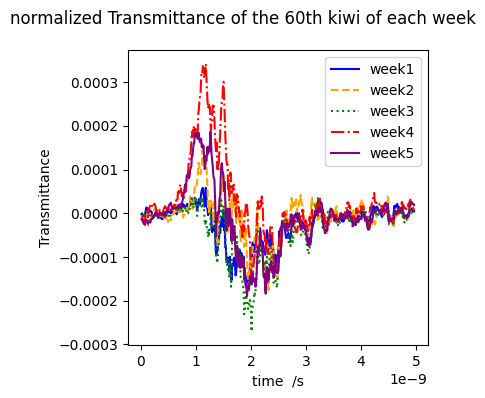

In [64]:
##########################################
fig = plt.figure(figsize = (4,4))
m = 60
fig.suptitle('normalized Transmittance of the '+str(m)+'th kiwi of each week')
line = []
for i in range(1,AMOUNT_EXP):
    line0 = []
    plt.rc('axes', prop_cycle=(cycler('color', ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','darkred']) +
                           cycler('linestyle', ['-', '--', ':', '-.','-','--',':','-.','-','--',':'])))
    line0, = plt.plot(TIME[0][i]*1e-9,Y_normalized[i,m,0:480])
    line.append(line0)
# plt.title.set_text(dict0[i][9:-4])
fig.tight_layout(pad=1.1)
plt.legend(line,['week1','week2','week3','week4','week5','day8','day9','day11','day13','day15','day17'])
plt.xlabel('time  /s')
plt.ylabel('Transmittance')
plt.show()

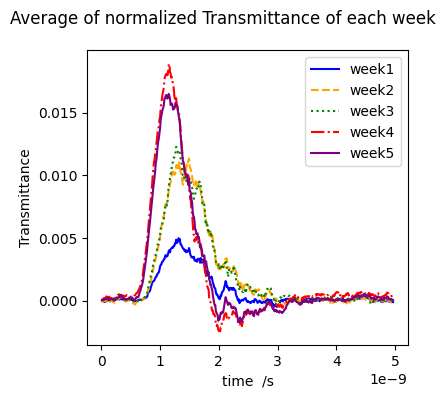

In [65]:
Y_norm2 = np.sum(Y_normalized,axis = 1)
##########################################
fig = plt.figure(figsize = (4,4))
fig.suptitle('Average of normalized Transmittance of each week')
line = []
for i in range(1,AMOUNT_EXP):
    line0 = []
    plt.rc('axes', prop_cycle=(cycler('color', ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','darkred']) +
                           cycler('linestyle', ['-', '--', ':', '-.','-','--',':','-.','-','--',':'])))
    line0, = plt.plot(TIME[0][i]*1e-9,Y_norm2[i,0:480])
    line.append(line0)
# plt.title.set_text(dict0[i][9:-4])
fig.tight_layout(pad=1.1)
plt.legend(line,['week1','week2','week3','week4','week5','day8','day9','day11','day13','day15','day17'])
plt.xlabel('time  /s')
plt.ylabel('Transmittance')
plt.show()

In [19]:
# 先平均再PCA
# 将第三维展开为一个向量
Y_tobepca = Y_norm2
# X = Y_tobepca.reshape(Y_tobepca.shape[0]*Y_tobepca.shape[1], 959)
X = Y_tobepca
# 创建PCA对象并拟合数据
n_components = 4
pca = PCA(n_components)
pca.fit(X)

# 转换数据并提取主成分
Z = pca.transform(X)

# 将数据转换回三维形式
# featrues = Z.reshape(Y_tobepca.shape[0],Y_tobepca.shape[1], n_components)
featrues = Z
# 输出转换后的数据形状
# print(Z_3d.shape)


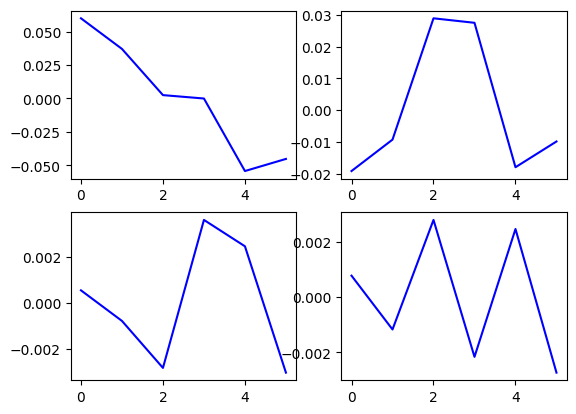

In [20]:
# 先平均再PCA
for i in range(n_components):
    plt.subplot(2,2,i+1)
    plt.plot(featrues[:,i])


In [66]:
# 先PCA再平均
# 将第三维展开为一个向量
Y_tobepca = Y_normalized[1:]
X = Y_tobepca.reshape(Y_tobepca.shape[0]*Y_tobepca.shape[1], 959)

# 创建PCA对象并拟合数据
n_components = 3
pca = PCA(n_components)
pca.fit(X)

# 转换数据并提取主成分
Z = pca.transform(X)

# 将数据转换回三维形式
featrues = Z.reshape(Y_tobepca.shape[0],Y_tobepca.shape[1], n_components)

# 输出转换后的数据形状
# print(Z_3d.shape)


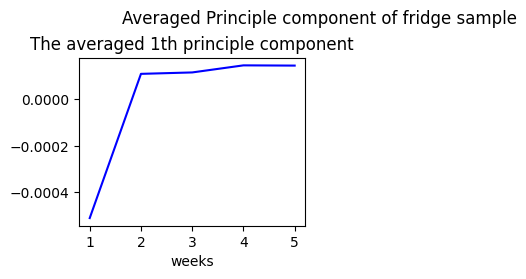

In [75]:
# 先PCA再平均
plt.suptitle('Averaged Principle component of fridge sample')
feature_sum= np.mean(featrues,axis = 1)
for i in range(1):
    ax0=plt.subplot(2,2,i+1)
    plt.title('The averaged '+str(i+1)+'th principle component')
    ax0.set_xticks([1,2,3,4,5])
    ax0.plot([1,2,3,4,5],feature_sum[:,i])
    ax0.set_xticks([1,2,3,4,5])
    ax0.set_xlabel('weeks')
plt.show()

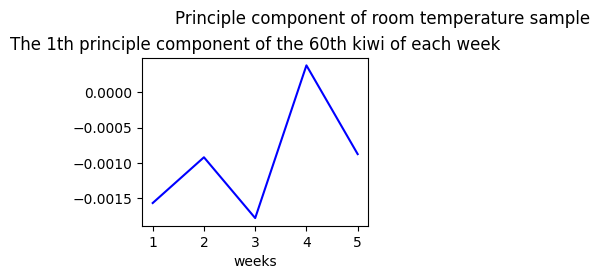

In [68]:
# 一个果的PCA特征值
j = m
plt.suptitle('Principle component of room temperature sample')
for i in range(1):  #n_components
    ax = plt.subplot(2,2,i+1)
    plt.title('The '+str(i+1)+'th principle component of the '+str(j)+'th kiwi of each week')
    ax.plot([1,2,3,4,5],featrues[:,j,i])   
    fig.tight_layout(pad=1.5)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xlabel('weeks')
plt.show()

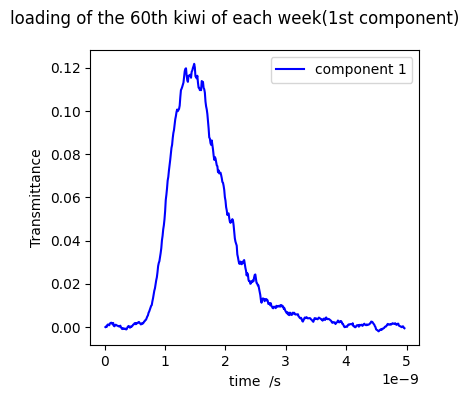

In [74]:
#loading，还原，只一个果
loading = pca.components_


##########################################
fig = plt.figure(figsize = (4,4))
fig.suptitle('loading of the '+str(m)+'th kiwi of each week(1st component)')
line = []
for i in range(1): #n_components
    line0 = []
    plt.rc('axes', prop_cycle=(cycler('color', ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','darkred']) +
                           cycler('linestyle', ['-', '--', ':', '-.','-','--',':','-.','-','--',':'])))
    line0, = plt.plot(TIME[0][i]*1e-9,loading[i,0:480])
    line.append(line0)
fig.tight_layout(pad=1.1)
plt.legend(line,['component 1','2','3','week4','week5','day8','day9','day11','day13','day15','day17'])
plt.xlabel('time  /s')
plt.ylabel('Transmittance')
plt.show()

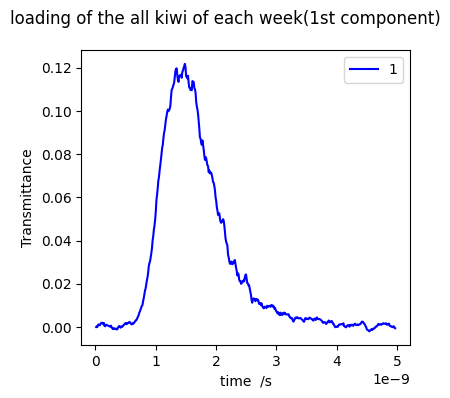

In [76]:
#loading，所有果
loading = pca.components_


##########################################
fig = plt.figure(figsize = (4,4))
fig.suptitle('loading of the all kiwi of each week(1st component)')
line = []
for i in range(1):  #n_components
    line0 = []
    plt.rc('axes', prop_cycle=(cycler('color', ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','darkred']) +
                           cycler('linestyle', ['-', '--', ':', '-.','-','--',':','-.','-','--',':'])))
    
    line0, = plt.plot(TIME[0][i]*1e-9,loading[i,0:480])
    line.append(line0)
fig.tight_layout(pad=1.1)
plt.legend(line,['1','2','3','week4','week5','day8','day9','day11','day13','day15','day17'])
plt.xlabel('time  /s')
plt.ylabel('Transmittance')
plt.show()

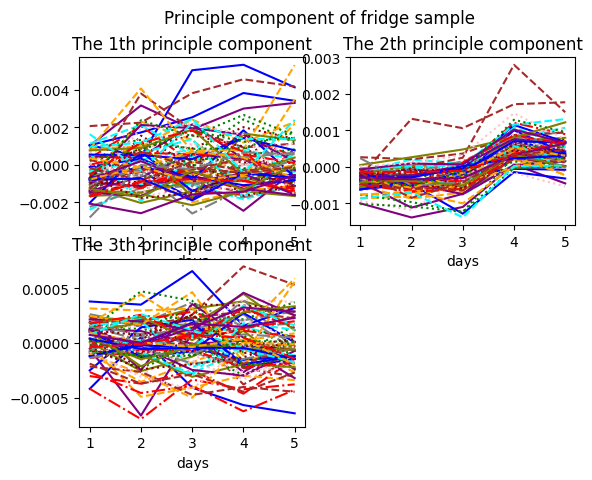

In [73]:
# 所有果的PCA特征值
plt.suptitle('Principle component of fridge sample')
for i in range(n_components):
    ax = plt.subplot(2,2,i+1)
    plt.title('The '+str(i+1)+'th principle component')
    for j in range(featrues.shape[1]):
        ax.plot([1,2,3,4,5],featrues[:,j,i])   
    fig.tight_layout(pad=1.5)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xlabel('days')
plt.show()

In [16]:
data1 = pd.read_excel('./kiwi_data.xlsx',sheet_name='冷库硬度',header=None)
# data2 = np.array(np.array(data1))

In [17]:
stiffness = np.zeros((int(29/5)+1,))
i=0
j= 0
while(i<29):
    stiffness[j] = (data1.iat[i+1,1]+data1.iat[i+1,2]+data1.iat[i+2,1]+data1.iat[i+2,2]+data1.iat[i+3,1]+data1.iat[i+3,2])/6
    i=i+5
    j=j+1

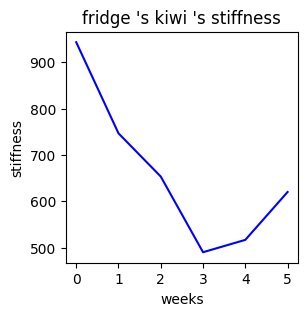

In [48]:
plt.figure(figsize = (3,3))
plt.title('fridge \'s kiwi \'s stiffness')
plt.plot([0,1,2,3,4,5],stiffness)
# plt.plot([1,2,3,4,5],feature_sum[:,0])
plt.xticks([0,1,2,3,4,5])
plt.xlabel('weeks')
plt.ylabel('stiffness')
plt.show()